In [1]:
import tensorflow as tf
import numpy as np
import sys


backend = tf.keras.backend
models = tf.keras.models
layers = tf.keras.layers

# GPU 지정
np.set_printoptions(threshold=sys.maxsize)
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'XLA_GPU')

# load data

X_train -> train image, crop + resize 512

y_train -> mask image, crop + resize 512

In [3]:
X_train1 = np.load('C:/jupyter/Tensorflow_tutorial/train_data/image1.npy')
X_train2 = np.load('C:/jupyter/Tensorflow_tutorial/train_data/image2.npy')
y_train = np.load('C:/jupyter/Tensorflow_tutorial/train_data/mask_image.npy')

In [4]:
# 파일을 불러오고, 데이터셋을 나눔 ( 크기가 너무 커서 )
# X_train ( training image ), y_train ( ground Truth ), valid ( validation data )
y_train1 = y_train[:5000]
y_train2 = y_train[5000:]
X_valid = X_train2[4500:]
y_valid = y_train2[4500:]

In [6]:
print('X_train1 : ', X_train1.shape, '\nX_train2 : ', X_train2.shape, '\ny_train1 : ', y_train1.shape, '\ny_train2 : ', y_train2.shape)
print('X_valid : ', X_valid.shape, '\ny_valid : ', y_valid.shape)

X_train1 :  (5000, 512, 512, 3) 
X_train2 :  (5015, 512, 512, 3) 
y_train1 :  (5000, 512, 512, 1) 
y_train2 :  (5015, 512, 512, 1)
X_valid :  (515, 512, 512, 3) 
y_valid :  (515, 512, 512, 1)


In [7]:
# 연산을 위한 형변환 및 numpy array 변환
# float은 255.0, int는 255로 나누어서 normalization
X_train1 = np.array(X_train1, dtype = np.float32)
X_train2 = np.array(X_train2, dtype = np.float32)
y_train1 = np.array(y_train1, dtype = np.int32)
y_train2 = np.array(y_train2, dtype = np.int32)
X_valid = np.array(X_valid, dtype = np.float32)
y_valid = np.array(y_valid, dtype = np.int32)

X_train1, X_train2 = X_train1 / 255.0, X_train2 / 255.0
y_train1, y_train2 = y_train1 / 255, y_train2 / 255
X_valid, y_valid = X_valid / 255.0, y_valid / 255

In [9]:
print('X_train1 : ', X_train1.shape, '\nX_train2 : ', X_train2.shape, '\ny_train1 : ', y_train1.shape, '\ny_train2 : ', y_train2.shape)
print('X_valid : ', X_valid.shape, '\ny_valid : ', y_valid.shape)

X_train1 :  (5000, 512, 512, 3) 
X_train2 :  (5015, 512, 512, 3) 
y_train1 :  (5000, 512, 512, 1) 
y_train2 :  (5015, 512, 512, 1)
X_valid :  (515, 512, 512, 3) 
y_valid :  (515, 512, 512, 1)


# Block

In [10]:
# ResNet에 사용되는 identity_block을 정의
# identity_block을 호출함으로써 사용 가능
class Identity_Block(tf.keras.Model):
    def __init__(self, filters, dilation = 1):
        super(Identity_Block, self).__init__()
        
        # filters 리스트를 입력받아 3개의 convolution layer의 filter 개수로 사용
        # ResNet 초반부 이후 추가적인 Down-Sampling은 없음, 그렇기에 padding same
        # Residual learning을 이용
        filters1, filters2, filters3 = filters
        
        
        self.conv1 = tf.keras.layers.Conv2D(filters1, kernel_size = (1, 1), strides = (1, 1)
                                            , padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters2, kernel_size = (3, 3), strides = (1, 1)
                                            , dilation_rate = 1, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters3, kernel_size = (1, 1), strides = (1, 1)
                                            , padding='same')
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.relu = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x = self.add([x, inputs])
        x = self.relu(x)
        
        return x

In [11]:
# ResNet에 사용되는 Convolution_block을 정의
# Conv_Block을 호출함으로써 사용 가능
class Conv_Block(tf.keras.Model):
    def __init__(self, filters, strides = (2, 2), dilation = 1):
        super(Conv_Block, self).__init__()
        
        
        # filters 리스트를 입력받아 4개의 convolution layer의 filter 개수로 사용
        # ResNet 초반부 이후 추가적인 Down-Sampling은 없음, 그렇기에 padding same
        # Strides는 2,2 로 설정한 후 맨 처음에만 1, 1로 사용하고 그 후엔 기본값인 2, 2를 사용
        filters1, filters2, filters3 = filters
            
        self.conv1 = tf.keras.layers.Conv2D(filters1, kernel_size = (1, 1), strides = strides
                                            , padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters2, kernel_size = (3, 3), strides = (1, 1)
                                            , dilation_rate = dilation, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters3, kernel_size = (1, 1), strides = (1, 1)
                                            , padding='same')  
        self.short_cut = tf.keras.layers.Conv2D(filters3, kernel_size = (1, 1)
                                               , strides = strides, padding = 'same')
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.relu = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        short_cut = self.short_cut(inputs)
        short_cut = self.bn4(short_cut)
        
        x = self.add([x, short_cut])
        x = self.relu(x)
        
        return x

In [12]:
# Modified ASPP에 사용되는 Dilated_Block을 정의
# Dilated_Block을 호출함으로써 사용 가능
class Dilated_Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, rate = 1):
        super(Dilated_Block, self).__init__()
        
        # Dilation_rate ( Atrous Convolution )을 통해서 같은 연산량으로 더 넓은 receptive field를 볼 수 있음
        self.bn = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.conv = layers.Conv2D(filters, kernel_size, padding = 'same', dilation_rate = rate)
        
    def call(self, inputs):
        
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        
        return x

In [13]:
class Segmentation_(tf.keras.Model):
    def __init__(self, num_classes):
        super(Segmentation_, self).__init__()
        
        # Segmentation에서 필요한 모든 layer를 정의된 function 등을 통해 정의
        # 이후 call 메서드에서 필요한 layer를 쌓으면 됨
        
        self.first_conv = tf.keras.layers.Conv2D(256, kernel_size = (2, 2), strides = (2, 2))
        self.first_pooling = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
        
        self.zero1 = tf.keras.layers.ZeroPadding2D(padding = (3, 3))
        self.zero2 = tf.keras.layers.ZeroPadding2D(padding = (1, 1))
        self.conv_1 = tf.keras.layers.Conv2D(64, kernel_size = (7, 7), strides = (2, 2))
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2))
        
        self.conv_2 = Conv_Block([64, 64, 256], strides = (1, 1))
        self.conv_3 = Conv_Block([128, 128, 512])
        self.conv_4 = Conv_Block([256, 256, 1024])
        self.conv_5 = Conv_Block([512, 512, 2048])
        
        self.identity_1 = Identity_Block([64, 64, 256])
        self.identity_2 = Identity_Block([128, 128, 512])
        self.identity_3 = Identity_Block([256, 256, 1024])
        self.identity_4 = Identity_Block([512, 512, 2048])
        
        self.conv1x1 = layers.Conv2D(64, 1, padding = 'same')
        self.conv17x17 = layers.Conv2D(128, 17, padding = 'same')
        self.conv13x13 = layers.Conv2D(128, 13, padding = 'same')
        self.conv9x9 = layers.Conv2D(128, 9, padding = 'same')
        self.conv5x5 = layers.Conv2D(128, 5, padding = 'same')
        
        self.conv3 = layers.Conv2D(128, 3, padding = 'same')
        self.conv5 = layers.Conv2D(128, 5, padding = 'same')
        self.conv7 = layers.Conv2D(128, 7, padding = 'same')
        
        self.mpooling1 = layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = 'same')
        self.mpooling2 = layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = 'same')
        self.mpooling3 = layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = 'same')
        self.mpooling4 = layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = 'same')
        
        self.dilated1 = Dilated_Block(128, 1)
        self.dilated2 = Dilated_Block(32, 3, rate = 3)
        
        self.dilated3 = Dilated_Block(128, 1)
        self.dilated4 = Dilated_Block(32, 3, rate = 6)
        
        self.dilated5 = Dilated_Block(128, 1)
        self.dilated6 = Dilated_Block(32, 3, rate = 12)
        
        self.upsam1 = layers.UpSampling2D(size = (4, 4))
        self.upsam2 = layers.UpSampling2D(size = (4, 4))
        
        self.outputs = layers.Conv2D(num_classes, 1, strides = 1)
        
        
        
    def call(self, inputs):
        
        # inputs = Detected Image
        # First Convolution Layer -> Image size = 1/4 
        x = self.first_conv(inputs)
        x = self.first_pooling(x)
        
        # ResNet101 -> Image size = 1/16
        # Convolution
        x = self.zero1(x)
        x = self.conv_1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.zero2(x)
        x = self.max_pool(x)
        
        # Residual learning
        # ResNet101 : [2, 3, 22, 2]
        x = self.conv_2(x)
        for i in range(2):
            x = self.identity_1(x)
        
        x = self.conv_3(x)
        for i in range(3):
            x = self.identity_2(x)

        x = self.conv_4(x)
        for i in range(22):
            x = self.identity_3(x)
        
        x = self.conv_5(x)
        for i in range(2):
            x = self.identity_4(x)
            
        
        # Modified ASPP
        # 1x1 convolution layer
        inpts = self.conv1x1(x)
        
        # conv 17, 13, 9, 5 / pooling 
        x_17 = self.conv17x17(inpts)
        x_17 = self.mpooling1(x_17)
        x_13 = self.conv13x13(inpts)
        x_13 = self.mpooling2(x_13)
        x_9 = self.conv9x9(inpts)
        x_9 = self.mpooling2(x_9)
        x_5 = self.conv5x5(inpts)
        x_5 = self.mpooling2(x_5)
        
        # conv 3, 5, 7
        x3 = self.conv3(inpts)
        x5 = self.conv5(inpts)
        x7 = self.conv7(inpts)
        
        dil3 = self.dilated1(inpts)
        dil3 = self.dilated2(dil3)
        
        n_inputs1 = backend.concatenate([inpts, dil3])
        
        dil6 = self.dilated3(n_inputs1)
        dil6 = self.dilated4(dil6)
        
        n_inputs2 = backend.concatenate([n_inputs1, dil6])
        
        dil12 = self.dilated5(n_inputs2)
        dil12 = self.dilated6(dil12)
        
        last_concat = backend.concatenate([inpts, x_17, x_13, x_9, x_5, x3, x5, x7, dil3, dil6, dil12])
        print(last_concat.shape)
        
        # outputs classes = 2, Up-Sampling -> original Image 
        x = self.outputs(last_concat)
        # Up-sampling = 4 x 4
        x = self.upsam1(x)
        x = self.upsam2(x)
        
        print(x.shape)
        
        return x

In [14]:
model = Segmentation_(2)

In [15]:
# dice_loss 수정 중

def dice_coeff(y_true, y_pred):
    smooth = 1.
    
    y_pred_ = tf.argmax(y_pred, axis = -1)
    y_pred_ = y_pred_[..., tf.newaxis]
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [16]:
# Adam의 rate를 조정 후, decay rate를 0.00005 사용
Adam = tf.optimizers.Adam(learning_rate=0.002, decay=0.00005)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer = Adam, 
             metrics = ['accuracy'])

In [17]:
model_history = model.fit(X_train1, y_train1, epochs = 10, 
                          validation_data=(X_valid, y_valid), 
                          batch_size = 8)

Epoch 1/10
(8, 32, 32, 1056)
(8, 512, 512, 2)
(8, 32, 32, 1056)
(8, 512, 512, 2)
625/625 [==============================] - ETA: 0s - loss: 2.2005 - accuracy: 0.8071(None, 32, 32, 1056)
(None, 512, 512, 2)
625/625 [==============================] - 416s 666ms/step - loss: 2.2005 - accuracy: 0.8071 - val_loss: 0.2493 - val_accuracy: 0.8976
Epoch 2/10
625/625 [==============================] - 413s 660ms/step - loss: 0.4030 - accuracy: 0.8389 - val_loss: 0.2732 - val_accuracy: 0.9105
Epoch 3/10
625/625 [==============================] - 413s 661ms/step - loss: 0.3886 - accuracy: 0.8455 - val_loss: 0.2212 - val_accuracy: 0.9189
Epoch 4/10
625/625 [==============================] - 415s 663ms/step - loss: 0.3830 - accuracy: 0.8490 - val_loss: 0.2314 - val_accuracy: 0.9113
Epoch 5/10
625/625 [==============================] - 415s 663ms/step - loss: 0.3860 - accuracy: 0.8488 - val_loss: 0.2339 - val_accuracy: 0.9163
Epoch 6/10
625/625 [==============================] - 415s 665ms/step - los

# Model Predict Ensemble

In [18]:
# Model training 이후 model predict ensemble을 위한 image rotate function 정의
def image_rotate_function(images):
    # 각각 원본이미지 / 90도 회전 / 180도 회전 / 뒤집은 이미지
    image1 = images
    image2 = np.rot90(images, 3)
    image3 = np.rot90(images, 2)
    image4 = np.flipud(images)
    
    return image1, image2, image3, image4

In [19]:
# predict에 사용할 이미지는 10개
X_train = X_train2[2000:2010] 
y_train = y_train2[2000:2010]

In [20]:
# rotate function을 이용해서 sample image rotate
image = []
image90 = []
image180 = []
image_flip = []

for i in range(10):
    x1, x2, x3, x4 = image_rotate_function(X_train[i])
    image.append(x1)
    image90.append(x2)
    image180.append(x3)
    image_flip.append(x4)
    
image = np.array(image)
image90 = np.array(image90)
image180 = np.array(image180)
image_flip = np.array(image_flip)

In [21]:
print('shape : ', image.shape)
print('shape : ', image90.shape)
print('shape : ', image180.shape)
print('shape : ', image_flip.shape)

shape :  (10, 512, 512, 3)
shape :  (10, 512, 512, 3)
shape :  (10, 512, 512, 3)
shape :  (10, 512, 512, 3)


In [22]:
# 각각의 회전된 이미지를 training 된 model을 통해서 predict를 내고, predict의 argmax를 통해 가장 높은 값을 출력
# 이미지 출력을 위해 새로운 차원을 추가 후 새로운 list에 append
def image_predict(images1, images2, images3, images4):
    
    a1 = []
    a2 = []
    a3 = []
    a4 = []
    
    pred1 = model.predict(images1)
    for i in range(10):
        x = tf.argmax(pred1[i], axis=-1)
        x = x[..., tf.newaxis]
        a1.append(x)
    
    pred2 = model.predict(images2)  
    for i in range(10):
        x = tf.argmax(pred2[i], axis=-1)
        x = x[..., tf.newaxis]
        a2.append(x)
        
    pred3 = model.predict(images3)
    for i in range(10):
        x = tf.argmax(pred3[i], axis=-1)
        x = x[..., tf.newaxis]
        a3.append(x)
    
    pred4 = model.predict(images4)
    for i in range(10):
        x = tf.argmax(pred4[i], axis=-1)
        x = x[..., tf.newaxis]
        a4.append(x)
    
    
    return a1, a2, a3, a4

In [23]:
# predict를 받아오고, list를 numpy array로 변환하고, shape을 확인

image_pred, image90_pred, image180_pred, image_flip_pred = image_predict(image, image90, image180, image_flip)

image_pred = np.array(image_pred)
print(image_pred.shape)

image90_pred = np.array(image90_pred)
print(image90_pred.shape)

image180_pred = np.array(image180_pred)
print(image180_pred.shape)

image_flip_pred = np.array(image_flip_pred)
print(image_flip_pred.shape)

(None, 32, 32, 1056)
(None, 512, 512, 2)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)


In [25]:
# 이미지를 다시 원상태로 되돌림
def revert_image(image_pred, image90_pred, image180_pred, image_flip_pred):
    
    image1 = image_pred
    image2 = np.rot90(image90_pred)
    image3 = np.rot90(image180_pred, 2)
    image4 = np.flipud(image_flip_pred)
    
    return image1, image2, image3, image4

In [26]:
# 뒤집은 이미지를 새로운 list에 저장하고, numpy array로 변환
image_ = []
image90_ = []
image180_ = []
image_flip_ = []

for i in range(10):
    x1, x2, x3, x4 = revert_image(image_pred[i], image90_pred[i], image180_pred[i], image_flip_pred[i])
    image_.append(x1)
    image90_.append(x2)
    image180_.append(x3)
    image_flip_.append(x4)
    
image_ = np.array(image_)
image90_ = np.array(image90_)
image180_ = np.array(image180_)
image_flip_ = np.array(image_flip_)

In [27]:
print('shape : ', image_.shape)
print('shape : ', image90_.shape)
print('shape : ', image180_.shape)
print('shape : ', image_flip_.shape)

shape :  (10, 512, 512, 1)
shape :  (10, 512, 512, 1)
shape :  (10, 512, 512, 1)
shape :  (10, 512, 512, 1)


In [28]:
# 이미지를 전부 더해서 평균을 구해주는 식으로 값을 나타냄
def add_array(image1, image2, image3, image4):
    
    x = np.add(image1, image2)
    x = np.add(x, image3)
    x = np.add(x, image4) / 4
    
    return x

In [29]:
real_image = []

for i in range(10):
    x = add_array(image_[i], image90_[i], image180_[i], image_flip_[i])
    real_image.append(x)
    
# 최종 predict 
real_image = np.array(real_image)

In [30]:
real_image.shape

(10, 512, 512, 1)

In [31]:
def display_(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

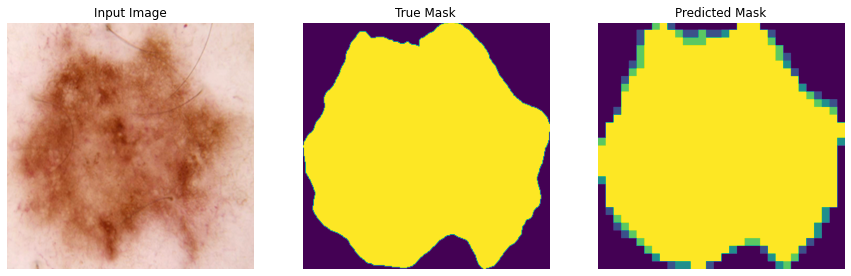

In [39]:
import matplotlib.pyplot as plt

for i in range(6):
    sample_images, sample_masks, pred = X_train[i], y_train[i], real_image[i]
display_([sample_images, sample_masks, pred])